https://www.youtube.com/watch?v=Z_ikDlimN6A&t=71011

# Standard setup

In [21]:
from torch.utils.data.dataset import Dataset
import torch
from torch import nn
from torch.utils.data import DataLoader, random_split

import torchvision
from torchvision import datasets
from torchvision.transforms import v2 as transforms

import random

import matplotlib.pyplot as plt
from tqdm.auto import tqdm

import requests
from pathlib import Path
import zipfile

from timeit import default_timer as timer

import os

try:
  import torchinfo
except:
  !pip install torchinfo
  import torchinfo

try:
  import torchmetrics, mlxtend
  assert int(mlxtend.__version__.split(".")[1])>=19, "mlxtend version should be 0.19.0 or higher"
except:
  !pip install torchmetrics -U mlxtend
  import torchmetrics, mlxtend

from torchmetrics import ConfusionMatrix
from mlxtend.plotting import plot_confusion_matrix
from typing import Tuple, Dict, List

print(f"PyTorch version: {torch.__version__}")
print(f"PyTorch torchvision version: {torchvision.__version__}")

device = torch.accelerator.current_accelerator() if torch.accelerator.is_available() else torch.device("cpu")
print(f"Torch device: {device}")
if torch.cuda.is_available():
    for device_id in range(torch.cuda.device_count()):
        print(f"Found CUDA device: cuda:{device_id} - {torch.cuda.get_device_name(device_id)}")

def plt_random_sample_from_data(data: Dataset, rows: int, cols: int, random_seed: int = None):
  if random_seed:
    random.seed(random_seed)
  samples = random.sample(list(data), rows*cols)

  fig = plt.figure(figsize=(rows*2,cols*2))
  for index, sample in enumerate(samples) :
    image = sample[0]
    label = sample[1]

    plt.subplot(cols, rows, index+1)
    plt.imshow(transforms.ToPILImage()(image))
    plt.title(f"{data.classes[label].capitalize()}\n{str(image.shape)[10:]}, {str(image.dtype)[6:]}", fontsize=8)
    plt.axis(False)
  fig.tight_layout()
  plt.show()

def print_train_time(start: float, end: float, device: torch.device = None):
    """Prints differene between start and end time."""
    total_time = end - start
    print(f"Train time on {device}: {total_time:.3f} seconds")
    return total_time

def plot_loss_curves(results: Dict[str, List[float]]):
    """Plots training curves of a results dictionary.

    Args:
        results (dict): dictionary containing list of values, e.g.
            {"train_loss": [...],
             "train_acc": [...],
             "test_loss": [...],
             "test_acc": [...]}
    """

    # Get the loss values of the results dictionary (training and test)
    loss = results['train_loss']
    test_loss = results['test_loss']

    # Get the accuracy values of the results dictionary (training and test)
    accuracy = results['train_acc']
    test_accuracy = results['test_acc']

    # Figure out how many epochs there were
    epochs = range(len(results['train_loss']))

    # Setup a plot
    plt.figure(figsize=(15, 7))

    # Plot loss
    plt.subplot(1, 2, 1)
    plt.plot(epochs, loss, label='train_loss')
    plt.plot(epochs, test_loss, label='test_loss')
    plt.title('Loss')
    plt.xlabel('Epochs')
    plt.legend()

    # Plot accuracy
    plt.subplot(1, 2, 2)
    plt.plot(epochs, accuracy, label='train_accuracy')
    plt.plot(epochs, test_accuracy, label='test_accuracy')
    plt.title('Accuracy')
    plt.xlabel('Epochs')
    plt.legend();

    plt.show()

PyTorch version: 2.8.0+cu126
PyTorch torchvision version: 0.23.0+cu126
Torch device: cuda
Found CUDA device: cuda:0 - Tesla T4


# Get our data

We're starting with the food 101 data set, but limiting it to 3 classes (Pizza, steak and sushi) and then only using 10% of the images from those classes for each of the training and test subsets.

In [2]:
data_path= Path("data/")
image_path= data_path / "pizza_steak_sushi"

# If the data already exists, don't download again
if image_path.is_dir():
  print(f"{image_path} directory already exists, not downloading")
else:
  print(f"{image_path} does not exist, creating")
  image_path.mkdir(parents=True, exist_ok=True)

with open(data_path / "pizza_steak_sushi.zip", "wb") as f:
  request = requests.get("https://github.com/mrdbourke/pytorch-deep-learning/raw/refs/heads/main/data/pizza_steak_sushi.zip")
  print("Downloading pizza, steak, sushi data")
  f.write(request.content)

with zipfile.ZipFile(data_path / "pizza_steak_sushi.zip", "r") as zip_ref:
  print("Unzipping pizza_steak_sushi data")
  zip_ref.extractall(image_path)

data/pizza_steak_sushi directory already exists, not downloading
Unzipping pizza_steak_sushi data


# Data preperation and data exploration

In [3]:
# def walk_through_dir(dir_path):
#   """Walks through a dir_path returning its contents."""
#   for dirpath, dirnames, filenames in os.walk(dir_path):
#     print(f"There are {len(dirnames)} and {len(filenames)} in '{dirpath}'")

# walk_through_dir(dir_path=image_path)

train_dir = image_path / "train"
test_dir = image_path / "test"

data_transform = transforms.Compose([
    transforms.Resize(size=(64,64), antialias=True),
    # Randomly flip on the horizontal axis, 50% of the images
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ToImage(),
    transforms.ToDtype(torch.float32, scale=True)
])

# You could also do this the hard way, see
# https://www.learnpytorch.io/04_pytorch_custom_datasets/#5-option-2-loading-image-data-with-a-custom-dataset
train_data = datasets.ImageFolder(root=train_dir,
                     transform=data_transform
                     )
test_data = datasets.ImageFolder(root=test_dir,
                     transform=data_transform
                     )

BATCH_SIZE = 32
SPARE_THREADS = 2

train_dataloader = DataLoader(dataset=train_data, batch_size=BATCH_SIZE, shuffle=True, num_workers=os.cpu_count())
test_dataloader = DataLoader(dataset=test_data, batch_size=BATCH_SIZE, shuffle=False, num_workers=os.cpu_count())

## Show a random image.

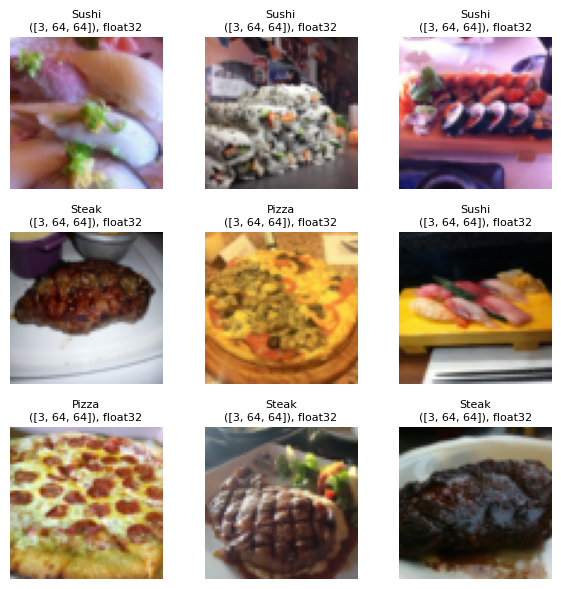

In [4]:
plt_random_sample_from_data(train_data, 3 ,3)

https://www.youtube.com/watch?v=Z_ikDlimN6A&t=80480

# Data Augmentation

Used to artificially increase the diversity in our training data

https://docs.pytorch.org/vision/stable/auto_examples/transforms/plot_transforms_illustrations.html#augmentation-transforms

Looking at one particular type of data augmentation used to train PyTorch vision models to (2022) state of the art levels.

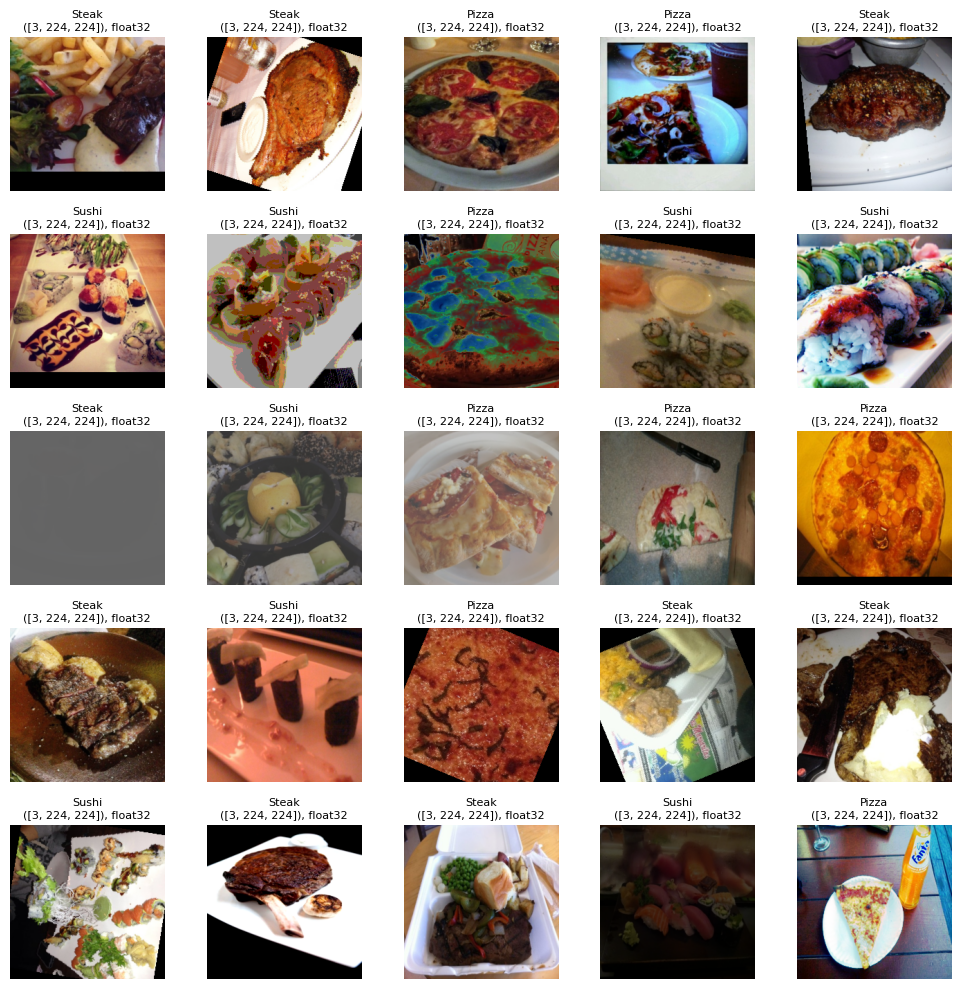

In [5]:
train_transform = transforms.Compose([
    transforms.Resize(size=(224,224)),
    transforms.TrivialAugmentWide(num_magnitude_bins=31),
    transforms.ToImage(),
    transforms.ToDtype(torch.float32, scale=True)
])

test_transform = transforms.Compose([
    transforms.Resize(size=(224,224)),
    transforms.ToImage(),
    transforms.ToDtype(torch.float32, scale=True)
])

train_data_augmented = datasets.ImageFolder(root=train_dir,
                     transform=train_transform
                     )
test_data_augmented = datasets.ImageFolder(root=test_dir,
                     transform=test_transform
                     )

plt_random_sample_from_data(train_data_augmented, cols=5, rows=5)

#Creating a model

https://www.youtube.com/watch?v=Z_ikDlimN6A&t=81767

In [6]:
BATCH_SIZE = 32
NUM_WORKERS = os.cpu_count()
train_dir = image_path / "train"
test_dir = image_path / "test"

simple_transform = transforms.Compose([
    transforms.Resize(size=(64,64)),
    transforms.ToImage(),
    transforms.ToDtype(torch.float32, scale=True)
])

train_data_simple = datasets.ImageFolder(root=train_dir,
                                         transform=simple_transform
                                         )
test_data_simple = datasets.ImageFolder(root=test_dir,
                                        transform=simple_transform
                                        )


train_dataloader_simple = DataLoader(dataset=train_data_simple,
                                     batch_size=BATCH_SIZE, shuffle=True,
                                     num_workers=NUM_WORKERS)
test_dataloader_simple = DataLoader(dataset=test_data_simple,
                                    batch_size=BATCH_SIZE, shuffle=False,
                                    num_workers=NUM_WORKERS)

In [7]:
#TinyVGG Baseline
class TinyVGG(nn.Module):
  """
  Model architecture that replicates the TinyVGG model from CNN explainer
  website. The data is expected to be a data batch, so 4 dimensions, and it
  works on RGB images of 64x64
  """
  def __init__(self, input_shape:int, hidden_units: int, output_shape: int):
    super().__init__()
    self.conv_block_1 = nn.Sequential(
        nn.Conv2d(in_channels=input_shape,
                  out_channels=hidden_units,
                  kernel_size=3,
                  stride=1,
                  padding=0),
        nn.ReLU(),
        nn.Conv2d(in_channels=hidden_units,
                  out_channels=hidden_units,
                  kernel_size=3,
                  stride=1,
                  padding=0),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2, stride=2)
    )
    self.conv_block_2 = nn.Sequential(
        nn.Conv2d(in_channels=hidden_units,
                  out_channels=hidden_units,
                  kernel_size=3,
                  stride=1,
                  padding=0),
        nn.ReLU(),
        nn.Conv2d(in_channels=hidden_units,
                  out_channels=hidden_units,
                  kernel_size=3,
                  stride=1,
                  padding=0),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2, stride=2)
    )
    self.classifier = nn.Sequential(
        nn.Flatten(),
        nn.Linear(in_features=hidden_units*13*13,
                  out_features=output_shape)
    )

  def forward(self, x: torch.Tensor) -> torch.Tensor:
    return self.classifier(self.conv_block_2(self.conv_block_1(x))) # benifits from operator fusion, see https://horace.io/brrr_intro.html


In [8]:
torch.manual_seed(42)
if torch.cuda.is_available():
  torch.cuda.manual_seed(42)

model_0 = TinyVGG(input_shape=3, hidden_units=10, output_shape=len(train_data_simple.classes)).to(device)

torchinfo.summary(model_0, input_size=[32,3,64,64])

Layer (type:depth-idx)                   Output Shape              Param #
TinyVGG                                  [32, 3]                   --
├─Sequential: 1-1                        [32, 10, 30, 30]          --
│    └─Conv2d: 2-1                       [32, 10, 62, 62]          280
│    └─ReLU: 2-2                         [32, 10, 62, 62]          --
│    └─Conv2d: 2-3                       [32, 10, 60, 60]          910
│    └─ReLU: 2-4                         [32, 10, 60, 60]          --
│    └─MaxPool2d: 2-5                    [32, 10, 30, 30]          --
├─Sequential: 1-2                        [32, 10, 13, 13]          --
│    └─Conv2d: 2-6                       [32, 10, 28, 28]          910
│    └─ReLU: 2-7                         [32, 10, 28, 28]          --
│    └─Conv2d: 2-8                       [32, 10, 26, 26]          910
│    └─ReLU: 2-9                         [32, 10, 26, 26]          --
│    └─MaxPool2d: 2-10                   [32, 10, 13, 13]          --
├─Sequentia

In [19]:
def model_train_step(model: torch.nn.Module,
               data_loader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               optimiser: torch.optim.Optimizer,
               device: torch.device = device):
    """Performs a training step with model trying to learn on data_loader"""

    train_loss, train_acc = 0, 0

    model.train()

    for batch, (X, y) in enumerate(data_loader):
        X, y = X.to(device), y.to(device)

        y_pred = model(X)

        loss = loss_fn(y_pred, y)
        train_loss += loss

        y_pred_class = torch.argmax(torch.softmax(y_pred, dim=1), dim=1)
        train_acc += (y_pred_class==y).sum().item()/len(y_pred)*100

        optimiser.zero_grad()

        loss.backward()

        optimiser.step()

    train_loss /= len(data_loader)
    train_acc /= len(data_loader)

    return train_loss, train_acc


def model_test_step(model: torch.nn.Module,
                 device: torch.device,
                 data_loader: torch.utils.data.DataLoader,
                 loss_fn: torch.nn.Module,
                 ):
    """Performs a testing step with model trying to test the trained model using data_loader"""
    test_loss, test_acc = 0, 0

    model.eval()
    with torch.inference_mode():
        for batch, (X,y) in enumerate(data_loader):
            X, y = X.to(device), y.to(device)
            test_pred = model(X)

            test_loss += loss_fn(test_pred, y)

            test_pred_class = torch.argmax(torch.softmax(test_pred, dim=1), dim=1)
            test_acc += (test_pred_class==y).sum().item()/len(test_pred)*100

        test_loss /= len(data_loader)
        test_acc /= len(data_loader)
    return test_loss, test_acc

def train(epochs: int, model: nn.Module,
          optimiser: torch.optim.Optimizer,
          train_dataloader: torch.utils.data.DataLoader,
          test_dataloader: torch.utils.data.DataLoader,
          loss_fn: torch.nn.Module,
          device: torch.device
          ):
  # 2. Create empty results dictionary
  results = {"train_loss": [],
      "train_acc": [],
      "test_loss": [],
      "test_acc": []
  }

  for epoch in tqdm(range(epochs), "Training..."):
      train_loss, train_acc = model_train_step(model=model,
                                               data_loader=train_dataloader,
                                               loss_fn=loss_fn,
                                               optimiser=optimiser,
                                               device=device)

      test_loss, test_acc = model_test_step(model=model,
                                              data_loader=test_dataloader,
                                              loss_fn=loss_fn, device=device)
      print(f"Epoch: {epoch}, Train loss: {train_loss:.4f}, Train acc: {train_acc:.2f}%, Test loss: {test_loss:.4f}, Test acc: {test_acc:.4f}%")

      # 5. Update results dictionary
      # Ensure all data is moved to CPU and converted to float for storage
      results["train_loss"].append(train_loss.item() if isinstance(train_loss, torch.Tensor) else train_loss)
      results["train_acc"].append(train_acc.item() if isinstance(train_acc, torch.Tensor) else train_acc)
      results["test_loss"].append(test_loss.item() if isinstance(test_loss, torch.Tensor) else test_loss)
      results["test_acc"].append(test_acc.item() if isinstance(test_acc, torch.Tensor) else test_acc)

  return results

Training...:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 0, Train loss: 1.1005, Train acc: 30.47%, Test loss: 1.0814, Test acc: 54.1667%
Epoch: 1, Train loss: 1.1040, Train acc: 28.12%, Test loss: 1.1006, Test acc: 19.7917%
Epoch: 2, Train loss: 1.0965, Train acc: 41.41%, Test loss: 1.1175, Test acc: 19.7917%
Epoch: 3, Train loss: 1.1066, Train acc: 29.30%, Test loss: 1.1216, Test acc: 19.7917%
Epoch: 4, Train loss: 1.0961, Train acc: 28.91%, Test loss: 1.1335, Test acc: 19.7917%
Train time on cuda:0: 20.843 seconds


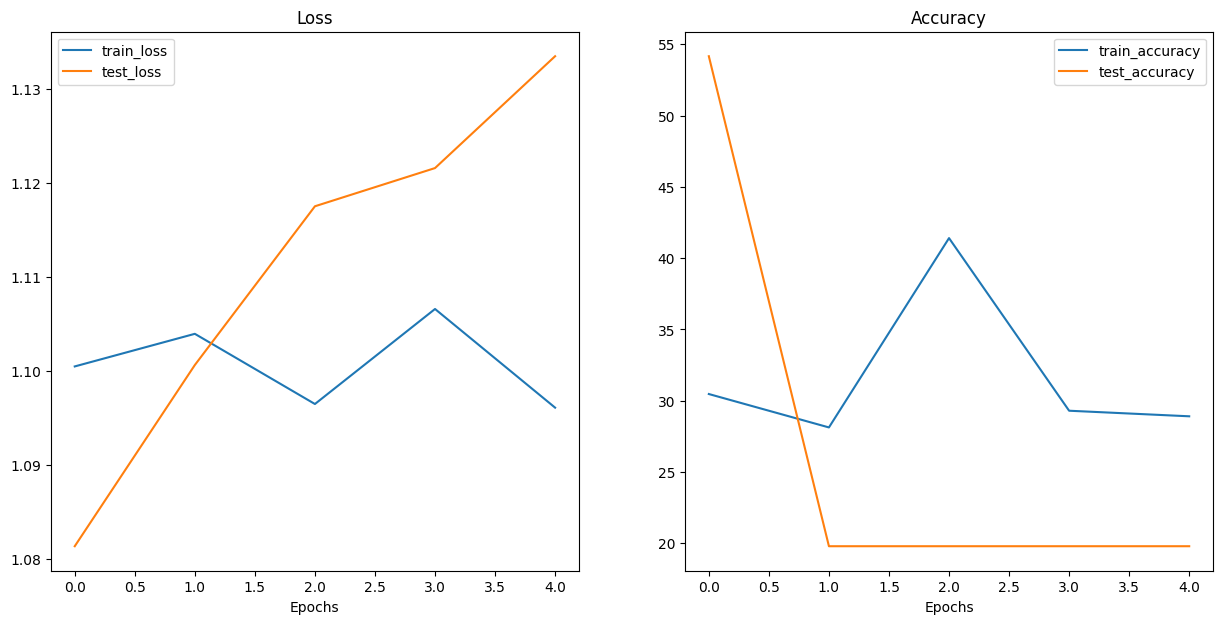

Making predictions...:   0%|          | 0/3 [00:00<?, ?it/s]

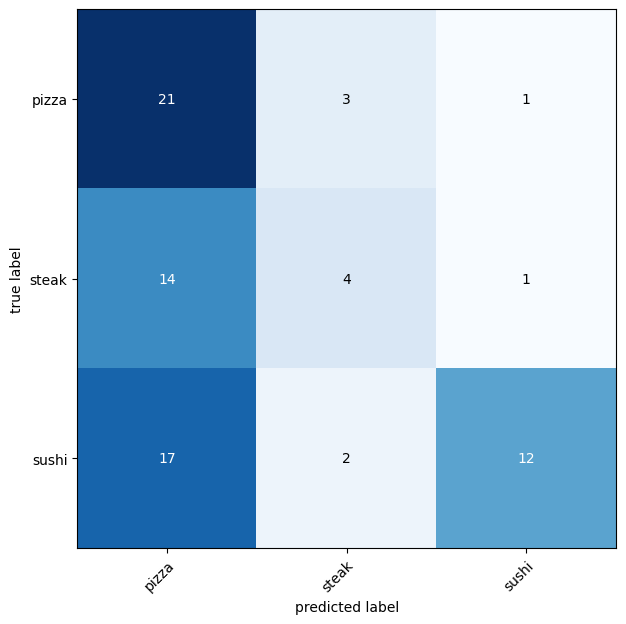

In [23]:
# Setup loss function
loss_fn = nn.CrossEntropyLoss()

# Setup optimiser function
optimiser = torch.optim.SGD(params=model_0.parameters(), lr=0.1)

EPOCHS = 5

train_time_start = timer()
model_0_results = train(epochs=EPOCHS, model=model_0, optimiser=optimiser,
      train_dataloader=train_dataloader_simple,
      test_dataloader=test_dataloader_simple, loss_fn=loss_fn, device=device)
train_time_end = timer()
total_train_time_model_0 = print_train_time(start=train_time_start,
                                            end=train_time_end,
                                            device=str(next(model_0.parameters()).device))

plot_loss_curves(model_0_results)

y_preds = []
targets = []
model_0.eval()
with torch.inference_mode():
    for X, y in tqdm(test_dataloader_simple, desc="Making predictions..."):
        X, y = X.to(device), y.to(device)
        y_logits = model_0(X)
        #Turn logits to preds to labels
        y_pred = torch.softmax(y_logits.squeeze(), dim=0).argmax(dim=1)
        y_preds.append(y_pred.cpu())
        targets.append(y)

y_pred_tensor = torch.cat(y_preds)
targets_tensor = torch.cat(targets).to("cpu")

conf_mat = ConfusionMatrix(num_classes=len(test_data_simple.classes), task="multiclass")
conf_mat_tensor = conf_mat(preds=y_pred_tensor, target=targets_tensor)

fig, axis = plot_confusion_matrix(conf_mat=conf_mat_tensor.numpy(),
                                  class_names=test_data_simple.classes,
                                  figsize=(10,7)
                                  )
fig.show()